# Introduction to LangChain 🦜️🔗 with Vertex AI

## Objectives

This notebook provides an introductory understanding of [Langchain](https://langchain.com/) components with Vertex PaLM APIs.

- Learn about LangChain and basic LangChain components
- Learn how to use Vertex AI with LangChain
- Learn how to call various Google LLM models using LangChain
- Learn how to create prompts and work with documents using LangChain


Topics covered in this notebook  
1. [Introduction to LangChain](#intro-to-langchain)
2. [LangChain Components](#langchain-components)
3. [Schema](#langchain-schema)
    - [Text](#langchain-components-text)
    - [Chat Messages](#langchain-components-chat)
    - [Documents](#langchain-components-documents)
4. [Models](#langchain-models)
    - [Language Model](#langchain-models-language)
    - [Chat Model](#langchain-models-chat)
    - [Text Embedding Models](#langchain-models-text-embeddings)
5. [Prompts](#langchain-prompts)
    - [Prompt Template](#langchain-prompts-template)
    - [Example Selectors](#langchain-prompts-example-selectors)
    - [Output Parsers](#langchain-prompts-output-parsers)
6. [Indexes](#langchain-indexes)
    - [Document Loaders](#langchain-indexes-document-loaders)
    - [Text Splitters](#langchain-indexes-text-splitters)
    - [Retrievers](#langchain-indexes-retrievers)
    - [Vector Stores](#langchain-indexes-vector-stores)




**References:**

- Adapted from [LangChain Cookbook](https://github.com/gkamradt/langchain-tutorials) from [Greg Kamradt](https://twitter.com/GregKamradt)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)
- [LangChain Python Documentation](https://python.langchain.com/en/latest/)


## **What is LangChain?** <a name="intro-to-langchain"/>

> LangChain is a framework for developing applications powered by large language models (LLMs).

**TL;DR** LangChain makes the complicated parts of working & building with language models easier. It helps do this in two ways:

1. **Integration** - Bring external data, such as your files, other applications, and API data, to LLMs
2. **Agents** - Allows LLMs to interact with its environment via decision making and use LLMs to help decide which action to take next

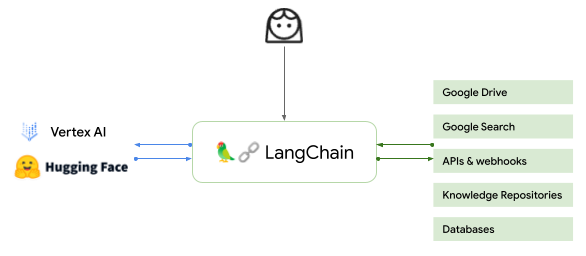


To build effective Generative AI applications, it is key to enable LLMs to interact with external systems. This makes models data-aware and agentic, meaning they can understand, reason, and use data to take action in a meaningful way. The external systems could be public data corpus, private knowledge repositories, databases, applications, APIs, or access to the public internet via Google Search.

Here are a few patterns where LLMs can be augmented with other systems:

- Convert natural language to SQL, executing the SQL on database, analyze and present the results
- Calling an external webhook or API based on the user query
- Synthesize outputs from multiple models, or chain the models in a specific order

It may look trivial to plumb these calls together and orchestrate them but it becomes a mundane task to write glue code again and again e.g. for every different data connector or a new model. That’s where LangChain comes in!

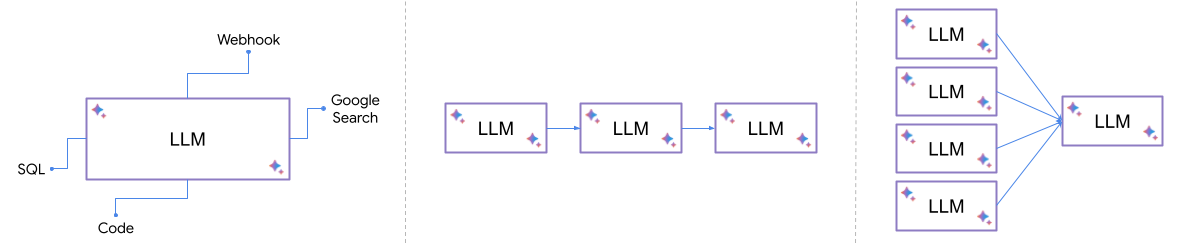


#### **Why LangChain?**

LangChain’s modular implementation of components and common patterns combining these components makes it easier to build complex applications based on LLMs. LangChain enables these models to connect to data sources and systems as agents to take action.

1. **Components** are abstractions that works to bring external data, such as your documents, databases, applications,APIs to language models. LangChain makes it easy to swap out abstractions and components necessary to work with LLMs.

2. **Agents** enable language models to communicate with its environment, where the model then decides the next action to take. LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together.

Though LLMs can be straightforward (text-in, text-out) you'll quickly run into friction points that LangChain helps with once you develop more complicated applications.

#### LangChain & Vertex AI

[Vertex AI PaLM foundational models](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) — Text, Chat, and Embeddings — are officially integrated with the [LangChain Python SDK](https://python.langchain.com/en/latest/index.html), making it convenient to build applications on top of Vertex AI PaLM models. You can now create Generative AI applications by combining the power of Vertex PaLM models with the ease of use and flexibility of LangChain.

- [LangChain with Vertex AI PaLM for LLMs](https://python.langchain.com/docs/integrations/llms/google_vertex_ai_palm)
- [LangChain with Vertex AI PaLM for Chat](https://python.langchain.com/docs/integrations/chat/google_vertex_ai_palm)
- [LangChain with Vertex AI Embedding API for Text](https://python.langchain.com/docs/integrations/text_embedding/google_vertex_ai_palm)

---

_Note: This notebook does not cover all aspects of LangChain. Its contents have been curated to get you to building & impact as quick as possible. For more, please check out [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)_


### Import libraries


In [ ]:
# pip install langchain-core==0.1.45 langchain-google-vertexai==1.0.1 unstructured==0.14.4

In [ ]:
PROJECT_ID = !gcloud config list --format 'value(core.project)'
PROJECT_ID = PROJECT_ID[0]
REGION = "us-central1"

In [ ]:
import time
from typing import List

# LangChain
import langchain
import vertexai
from google.cloud import aiplatform
from langchain.chat_models import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings

# Utils
from langchain.schema import HumanMessage, SystemMessage
from langchain_google_vertexai import VertexAI
from pydantic import BaseModel

print(f"LangChain version: {langchain.__version__}")

# Vertex AI

print(f"Vertex AI SDK version: {aiplatform.__version__}")

vertexai.init(project=PROJECT_ID, location=REGION)

Next you will define some utility functions that you will use for the Vertex AI Embeddings API


In [ ]:
# Utility functions for Embeddings API with rate limiting


def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

Define LangChain Models using Vertex AI PaLM API for Text, Chat and Vertex AI Embedding for Text


In [ ]:
# LLM model
llm = VertexAI(
    model_name="text-bison@002",
    max_output_tokens=1024,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Chat
chat = ChatVertexAI()  # default model: chat-bison

# Embedding
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

# LangChain Components <a name="langchain"/>

Let’s take a quick tour of LangChain framework and concepts to be aware of. LangChain offers a variety of modules that can be used to create language model applications. These modules can be combined to create more complex applications, or can be used individually for simpler applications.

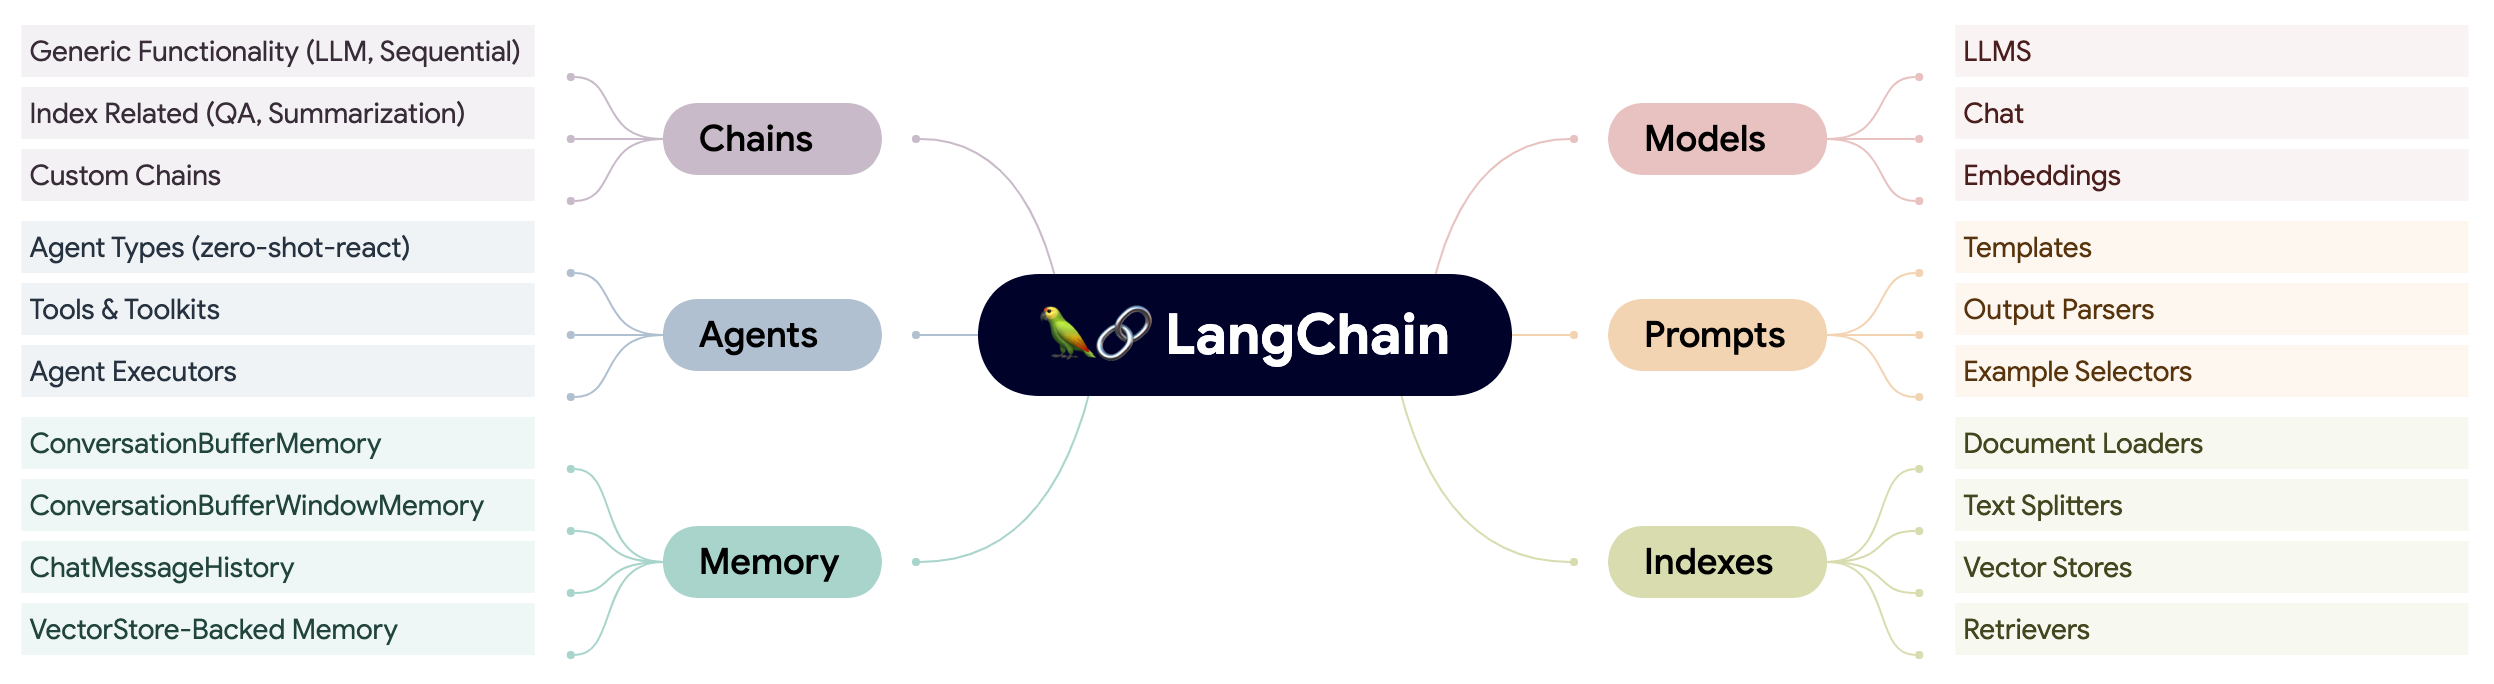


- **Models** are the building block of LangChain providing an interface to different types of AI models. Large Language Models (LLMs), Chat and Text Embeddings models are supported model types.
- **Prompts** refers to the input to the model, which is typically constructed from multiple components. LangChain provides interfaces to construct and work with prompts easily - Prompt Templates, Example Selectors and Output Parsers.
- **Memory** provides a construct for storing and retrieving messages during a conversation which can be either short term or long term.
- **Indexes** help LLMs interact with documents by providing a way to structure them. LangChain provides Document Loaders to load documents, Text Splitters to split documents into smaller chunks, Vector Stores to store documents as embeddings, and Retrievers to fetch relevant documents.
- **Chains** let you combine modular components (or other chains) in a specific order to complete a task.
- **Agents** are a powerful construct in LangChain allowing LLMs to communicate with external systems via Tools and observe and decide on the best course of action to complete a given task.


## Schema - Nuts and Bolts of working with LLMs <a name="langchain-schema"/>

### **Text** <a name="langchain-components-text"/>

Text is the natural language way to interact with LLMs.


In [ ]:
# You'll be working with simple strings (that'll soon grow in complexity!)
my_text = "What day comes after Friday?"

llm(my_text)

### **Chat Messages** <a name="langchain-components-chat"/>

Chat is like text, but specified with a message type (System, Human, AI)

- **System** - Helpful context that tells the AI what to do
- **Human** - Messages intended to represent the user
- **AI** - Messages showing what the AI responded with

For more information, see [LangChain Documentation for Chat Models](https://python.langchain.com/docs/modules/model_io/chat).


In [ ]:
chat([HumanMessage(content="Hello")])

In [ ]:
res = chat(
    [
        SystemMessage(
            content="You are a chef who will help the user figure out what they can eat"
        ),
        HumanMessage(content="I like tomatoes, what should I eat?"),
    ]
)

print(res.content)

You can also pass more chat history w/ responses from the AI


In [ ]:
res = chat(
    [
        HumanMessage(
            content="What are the ingredients required to make Bruschetta with tomatoes?"
        )
    ]
)
print(res.content)

In [ ]:
res = chat(
    [
        HumanMessage(
            content="I don't have olive oil. Can I substitute something for it?"
        )
    ]
)
print(res.content)

### **Documents** <a name="langchain-components-documents"/>

Document in LangChain refers to an unstructured text consisting of `page_content` referring to the content of the data and `metadata` (data describing attributes of page content).


In [ ]:
from langchain.schema import Document

In [ ]:
Document(
    page_content="This is my document. It is full of text that I've gathered from other places",
    metadata={
        "my_document_id": 234234,
        "my_document_source": "The LangChain Papers",
        "my_document_create_time": 1680013019,
    },
)

## **Models - The interface to the AI brains** <a name="langchain-models"/>

LangChain supports 3 model primitives:

- LLMs
- Chat Models
- Text Embedding Models


### **Language Model** <a name="langchain-models-language"/>

Language model does text in ➡️ text out!

[LangChain LLMs](https://python.langchain.com/docs/integrations/llms/google_vertex_ai_palm) are integrate with [Vertex AI models](https://cloud.google.com/vertex-ai/docs/generative-ai/text/text-overview).


In [ ]:
llm("What day comes after Friday?")

### **Chat Model** <a name="langchain-models-chat"/>

Chat model that takes a series of messages and returns a message output.

[LangChain Chat Model](https://python.langchain.com/en/latest/modules/models/chat/integrations/google_vertex_ai_palm.html) integrate with [Vertex AI models for chat](https://cloud.google.com/vertex-ai/docs/generative-ai/chat/chat-prompts).


In [ ]:
res = chat(
    [
        SystemMessage(
            content="You are a travel agent who will help the user figure out what they can do when they travel."
        ),
        HumanMessage(
            content="I would like to go to New York, what places do you recommend I visit?"
        ),
    ]
)
print(res.content)

### **Text Embedding Model** <a name="langchain-models-text-embeddings"/>

[Embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings) are a way of representing data–almost any kind of data, like text, images, videos, users, music, whatever–as points in space where the locations of those points in space are semantically meaningful. Embeddings transform your text into a vector (a series of numbers that hold the semantic 'meaning' of your text). Vectors are often used when comparing two pieces of text together. An [embedding](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) is a relatively low-dimensional space into which you can translate high-dimensional vectors.

[LangChain Text Embedding Model](https://python.langchain.com/en/latest/modules/models/text_embedding/examples/google_vertex_ai_palm.html) integrate with [Vertex AI Embedding API for Text](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings).

_BTW: Semantic means 'relating to meaning in language or logic.'_


In [ ]:
text = "Hi! It's time for summer break!"

In [ ]:
text_embedding = embeddings.embed_query(text)
print(f"Your embedding is length {len(text_embedding)}")
print(f"Here's a sample: {text_embedding[:5]}...")

## **Prompts** <a name="langchain-prompts"/>

Prompts are text used as instructions to your model.

In [ ]:
prompt = """
Today is Monday, tomorrow is Wednesday.

What is wrong with that statement?
"""

llm(prompt)

### **Prompt Template** <a name="langchain-prompts-template"/>

[Prompt Template](https://python.langchain.com/v0.2/docs/concepts/#prompt-templates) is an object that helps to create prompts based on a combination of user input, other non-static information and a fixed template string.

Think of it as an [f-string](https://realpython.com/python-f-strings/) in python but for prompts


In [ ]:
from langchain import PromptTemplate

# Notice "location" below, that is a placeholder for another value later
template = """
I really want to travel to {location}. What should I do there?

Respond in one short sentence
"""

prompt = PromptTemplate(
    input_variables=["location"],
    template=template,
)

final_prompt = prompt.format(location="Spain")

print(f"Final Prompt: {final_prompt}")
print("-----------")
print(f"LLM Output: {llm(final_prompt)}")

### **Example Selectors** <a name="langchain-prompts-example-selectors"/>

[Example selectors](https://python.langchain.com/v0.2/docs/concepts/#example-selectors) are an easy way to select from a series of examples to dynamically place in-context information into your prompt. Often used when the task is nuanced or has a large list of examples.

Check out different types of example selectors [here](https://python.langchain.com/docs/modules/model_io/prompts/example_selectors/)


In [ ]:
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Examples of locations that nouns are found
examples = [
    {"input": "pirate", "output": "ship"},
    {"input": "pilot", "output": "plane"},
    {"input": "driver", "output": "car"},
    {"input": "tree", "output": "ground"},
    {"input": "bird", "output": "nest"},
]

In [ ]:
# SemanticSimilarityExampleSelector will select examples that are similar to your input by semantic meaning

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    embeddings,
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # This is the number of examples to produce.
    k=2,
)

In [ ]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,
    # Your prompt
    example_prompt=example_prompt,
    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the location an item is usually found in",
    suffix="Input: {noun}\nOutput:",
    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [ ]:
# Select a noun!
my_noun = "student"

print(similar_prompt.format(noun=my_noun))

In [ ]:
llm(similar_prompt.format(noun=my_noun))

### **Output Parsers** <a name="langchain-prompts-output-parsers"/>

[Output Parsers](https://python.langchain.com/docs/modules/model_io/output_parsers/) help to format the output of a model. Usually used for structured output.

Two main ideas:

**1. Format Instructions**: An autogenerated prompt that tells the LLM how to format it's response based off desired result

**2. Parser**: A method to extract model's text output into a desired structure (usually json)


In [ ]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

In [ ]:
# How you would like your reponse structured. This is basically a fancy prompt template
response_schemas = [
    ResponseSchema(
        name="bad_string",
        description="This a poorly formatted user input string",
    ),
    ResponseSchema(
        name="good_string",
        description="This is your response, a reformatted response",
    ),
]

# How you would like to parse your output
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [ ]:
# See the prompt template you created for formatting
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

In [ ]:
template = """
You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly including country, city and state names

{format_instructions}

% USER INPUT:
{user_input}

YOUR RESPONSE:
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template,
)

promptValue = prompt.format(user_input="welcom to dbln!")

print(promptValue)

In [ ]:
llm_output = llm(promptValue)
llm_output

In [ ]:
output_parser.parse(llm_output)

## Indexes - Structuring documents so LLMs can work with them <a name="langchain-indexes"/>
 
Indexes refer to ways to structure documents for LLMs to work with them.


### **Document Loaders** <a name="langchain-indexes-document-loaders"/>

Dcoument loaders are ways to import data from other sources. See the [large](https://python.langchain.com/v0.2/docs/integrations/document_loaders/) of document loaders here. There are more on [Llama Index](https://llamahub.ai/) as well that work with LangChain Document Loaders.


Here are a few examples of the loaders you can try. 


**HackerNews**

In [ ]:
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
from langchain.document_loaders import HNLoader  # HackerNews Loader

data = loader.load()
print(f"Found {len(data)} comments")
print(
    f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}"
)

**Books from Gutenberg Project**

In [ ]:
from langchain.document_loaders import GutenbergLoader

loader = GutenbergLoader("https://www.gutenberg.org/cache/epub/2148/pg2148.txt")

data = loader.load()

In [ ]:
print(data[0].page_content[1855:1984])

**URLs and webpages**

Let's try it out with [Andrew Ng's website](https://www.andrewng.org/)

In [ ]:
from langchain.document_loaders import UnstructuredURLLoader

urls = [
    "https://www.andrewng.org/",
]

loader = UnstructuredURLLoader(urls=urls)

webpage_data = loader.load()

webpage_data[0].page_content

### **Text Splitters** <a name="langchain-indexes-text-splitters"/>

[Text Splitters](https://python.langchain.com/docs/modules/data_connection/document_transformers/) are a way to deal with input token limits of LLMs by splitting text into chunks.

There are many ways you could split your text into chunks, experiment with [different ones](https://python.langchain.com/docs/modules/data_connection/document_transformers/) to see which is best for your use case.


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=20,
)

texts = text_splitter.split_documents(webpage_data)

In [ ]:
print(f"You have {len(texts)} documents")

In [ ]:
print("Preview:")
print(texts[0].page_content, "\n")
print(texts[1].page_content)

### **Retrievers** <a name="langchain-indexes-retrievers"/>

[Retrievers](https://python.langchain.com/docs/modules/data_connection/retrievers) are a way of storing data such that it can be queried by a language model. Easy way to combine documents with language models.

There are [many different types of retrievers](https://python.langchain.com/docs/modules/data_connection/retrievers.html#advanced-retrieval-types), the most widely supported is the `VectorStoreRetriever`.


Here we use [Facebook AI Similarity Search (FAISS)](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/), a library and a vector database for similarity search and clustering of dense vectors. To generate dense vectors, a.k.a. embeddings, we use [LangChain text embeddings model with Vertex AI Embeddings for Text](https://python.langchain.com/docs/integrations/text_embedding/google_vertex_ai_palm) .


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

In [ ]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, chunk_overlap=50
)

# Split your docs into texts
texts = text_splitter.split_documents(webpage_data)

# Embed your texts
db = FAISS.from_documents(texts, embeddings)

In [ ]:
# Init your retriever. Asking for just 1 document back
retriever = db.as_retriever()
retriever

In [ ]:
docs = retriever.get_relevant_documents(
    "what types of things did the author want to develop or build?"
)

print("\n\n".join([x.page_content[:200] for x in docs[:2]]))

### **VectorStores** <a name="langchain-indexes-vector-stores"/>

[Vector Store](https://python.langchain.com/docs/modules/data_connection/vectorstores) is a common type of index or a database to store vectors (numerical embeddings). Conceptually, think of them as tables with a column for embeddings (vectors) and a column for metadata.

Example

| Embedding                                             | Metadata           |
| ----------------------------------------------------- | ------------------ |
| `[-0.00015641732898075134, -0.003165106289088726, ...]` | `{'date' : '1/2/23}` |
| `[-0.00035465431654651654, 1.4654131651654516546, ...]` | `{'date' : '1/3/23}` |

- [Chroma](https://www.trychroma.com/) & [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) are easy to work with locally.
- [Vertex AI Matching Engine](https://cloud.google.com/blog/products/ai-machine-learning/vertex-matching-engine-blazing-fast-and-massively-scalable-nearest-neighbor-search) is fully managed vector store on Google Cloud, developers can just add the embeddings to its index and issue a search query with a key embedding for the blazingly fast vector search.

<br/>

**[LangChain VectorStore is integrated with Vertex AI Vector Search (Matching Engine)](https://python.langchain.com/docs/integrations/vectorstores/google_vertex_ai_vector_search).**


In [ ]:
# Split your docs into texts
texts = text_splitter.split_documents(webpage_data)

In [ ]:
print(f"You have {len(texts)} documents")

In [ ]:
embedding_list = embeddings.embed_documents(
    [text.page_content for text in texts]
)

In [ ]:
print(f"You have {len(embedding_list)} embeddings")
print(f"Here's a sample of one: {embedding_list[0][:3]}...")

Vectorstore stores your embeddings (☝️) and make them easily searchable.


Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.